# PID, MPC, Offline, Offline + Online 평가

시뮬레이터를 통한 평가를 진행한다.

고정된 에피소드 7개에 대해 3개의 seed를 적용하여 L2(t,tsp)을 평균낸다.

In [ ]:
import tclab
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
import torch
import random
import os
root_path="/home/minchanggi/code/TCLab/data/eval_data"

epi_gen_seed=[0,1,2,3,4]
#epi_gen_seed=[ 98000+i for i in range(10)]
print(epi_gen_seed)
rl_seed=[0]
max_episode_steps=1200
sleep_max=1.0

[98000, 98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98009]


In [10]:
def save_csv_png(all_data,step_num):
    import csv
    import matplotlib.pyplot as plt
    for data in all_data:
        path = data["path"]
        tm = data["tm"]
        Q1 = data["Q1"]
        Q2 = data["Q2"]
        T1 = data["T1"]
        T2 = data["T2"]
        Tsp1 = data["Tsp1"]
        Tsp2 = data["Tsp2"]
        os.makedirs(path, exist_ok=True)
        csv_filename = os.path.join(path, f'episode_{step_num}_data.csv')
        with open(csv_filename, 'w', newline='') as fid:
            writer = csv.writer(fid)
            writer.writerow(['step_num', 'Time', 'Q1', 'Q2', 'T1', 'T2', 'TSP1', 'TSP2'])
            for i in range(len(tm)):
                writer.writerow([
                    step_num,
                    f"{tm[i]:.2f}", f"{Q1[i]:.2f}", f"{Q2[i]:.2f}",
                    f"{T1[i]:.2f}", f"{T2[i]:.2f}", f"{Tsp1[i]:.2f}", f"{Tsp2[i]:.2f}"
                ])

        plt.figure(figsize=(10, 7))
        ax = plt.subplot(2, 1, 1)
        ax.grid()
        plt.plot(tm, Tsp1, 'k--', label=r'$T_1$ set point')
        plt.plot(tm, T1, 'b.', label=r'$T_1$ measured')
        plt.plot(tm, Tsp2, 'k-', label=r'$T_2$ set point')
        plt.plot(tm, T2, 'r.', label=r'$T_2$ measured')
        plt.ylabel(r'Temperature ($^oC$)')
        plt.title(f'Episode {step_num}')
        plt.legend(loc='best')

        ax = plt.subplot(2, 1, 2)
        ax.grid()
        plt.plot(tm, Q1, 'b-', label=r'$Q_1$')
        plt.plot(tm, Q2, 'r:', label=r'$Q_2$')
        plt.ylabel('Heater Output (%)')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')

        plt.tight_layout()
        png_filename = os.path.join(path, f'episode_{step_num}_plot.png')
        plt.savefig(png_filename)
        plt.close()


def set_seed(seed, env=None):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    if env is not None:
        env.seed(seed)



def generate_random_tsp(length, name='TSP'):
    i = 0
    tsp = np.zeros(length)
    #print(f'duration {length}: [{name} 설정 정보]')
    while i < length:
        if length == 600: 
            duration = int(np.clip(np.random.normal(240, 50), 80, 400))
        elif length == 900:
            duration = int(np.clip(np.random.normal(360, 75), 120, 600))
        elif length == 1200:
            duration = int(np.clip(np.random.normal(480, 100), 160, 800))
        else:
            duration = 5
        temp = np.random.uniform(25, 65)
        end = min(i + duration, length)
        tsp[i:end] = temp
        #print("@@@@@@@@@@@@@@@@")
        #print(f'  구간: {i:>3} ~ {end - 1:>3}, 목표 온도: {temp:.2f}°C')
        i = end
    return tsp

## PID

In [11]:
# PID 상수
Kc   = 9.24
tauI = 126.6 # sec
tauD = 8.90  # sec
Kff  = -0.66
st_temp = 29.0

def pid(sp, pv, pv_last, ierr, dt, d, cid):
    if cid == 1:
        KP = Kc
        Kf = Kff
    else:
        KP = Kc * 2.0
        Kf = Kff * 2.0
    KI = Kc / tauI
    KD = Kc * tauD
    op0 = 0
    ophi = 100
    oplo = 0
    error = sp - pv
    ierr += KI * error * dt
    dpv = (pv - pv_last) / dt
    P = KP * error
    I = ierr
    D = -KD * dpv
    FF = Kf * d
    op = op0 + P + I + D + FF
    if op < oplo or op > ophi:
        I -= KI * error * dt
        op = max(oplo, min(ophi, op))
    return op, P, I, D, FF



PID_SIM_path=os.path.join(root_path,"PID_SIM")
PID_KIT_path=os.path.join(root_path,"PID_KIT")

# PID Sim

In [25]:
all_datas = []

for epi_seed in epi_gen_seed:
    set_seed(epi_seed)
    Tsp1 = generate_random_tsp(max_episode_steps, 'TSP1')
    Tsp2 = generate_random_tsp(max_episode_steps, 'TSP2')

    from tclab import setup
    lab = setup(connected=False)
    env = lab(synced=False)
    
    env.Q1(0)
    env.Q2(0)

    tm = np.zeros(max_episode_steps)
    T1 = np.ones(max_episode_steps) * env.T1
    T2 = np.ones(max_episode_steps) * env.T2
    Q1 = np.zeros(max_episode_steps)
    Q2 = np.zeros(max_episode_steps)
    total_reward = 0.0
    ierr1 = 0.0
    ierr2 = 0.0
    for i in range(max_episode_steps):
        sim_time = i * sleep_max
        env.update(t=sim_time)
        tm[i] = sim_time

        T1[i] = env.T1
        T2[i] = env.T2
        
        d1 = T1[i] - 23.0
        d2 = T2[i] - 23.0
        Q1[i],P,ierr1,D,FF = pid(Tsp1[i],T1[i],T1[i-1],ierr1,sleep_max,d2,1)
        Q2[i],P,ierr2,D,FF = pid(Tsp2[i],T2[i],T2[i-1],ierr2,sleep_max,d1,2)
        
        env.Q1(Q1[i])
        env.Q2(Q2[i])
        
        reward = -np.linalg.norm([T1[i] - Tsp1[i], T2[i] - Tsp2[i]])
        total_reward += reward
    path = os.path.join(PID_SIM_path, f"{epi_seed}epi")
    data={
        "path": path,
        "tm": tm,
        "Q1": Q1,
        "Q2": Q2,
        "T1": T1,
        "T2": T2,
        "Tsp1": Tsp1,
        "Tsp2": Tsp2,
        "total_reward": total_reward,
    }
    all_datas.append(data)
      
    env.close()

all_rewards = [d["total_reward"] for d in all_datas]

# 평균 계산 및 출력
mean_reward = np.mean(all_rewards)
print("Average Total Reward:", mean_reward)
save_csv_png(all_datas, 0)


Average Total Reward: -7277.138189436237


# PID 키트


In [ ]:
# PID 키트
all_datas = []
st_temp = 29.0

for epi_seed in epi_gen_seed:
    set_seed(epi_seed)
    Tsp1 = generate_random_tsp(max_episode_steps, 'TSP1')
    Tsp2 = generate_random_tsp(max_episode_steps, 'TSP2')

    env = tclab.TCLab()
    
    env.Q1(0)
    env.Q2(0)

    while env.T1 >= st_temp or env.T2 >= st_temp:
        print(f'Time: {i} T1: {env.T1} T2: {env.T2}')
        i += 20
        time.sleep(20)

    tm = np.zeros(max_episode_steps)
    T1 = np.ones(max_episode_steps) * env.T1
    T2 = np.ones(max_episode_steps) * env.T2
    Q1 = np.zeros(max_episode_steps)
    Q2 = np.zeros(max_episode_steps)
    total_reward = 0.0
    ierr1 = 0.0
    ierr2 = 0.0
    dt_error = 0.0
    start_time = time.time()
    prev_time = start_time
    for i in range(max_episode_steps):
        sleep = sleep_max - (time.time() - prev_time) - dt_error
        if sleep >= 1e-4:
            time.sleep(sleep - 1e-4)
        else:
            print('exceeded max cycle time by ' + str(abs(sleep)) + ' sec')
            time.sleep(1e-4)

        t = time.time()
        dt = t - prev_time
        if (sleep>=1e-4):
            dt_error = dt-sleep_max+0.009
        else:
            dt_error = 0.0
        prev_time = t
        tm[i] = t - start_time

        T1[i] = env.T1
        T2[i] = env.T2
        
        d1 = T1[i] - 23.0
        d2 = T2[i] - 23.0
        Q1[i],P,ierr1,D,FF = pid(Tsp1[i],T1[i],T1[i-1],ierr1,sleep_max,d2,1)
        Q2[i],P,ierr2,D,FF = pid(Tsp2[i],T2[i],T2[i-1],ierr2,sleep_max,d1,2)
        
        env.Q1(Q1[i])
        env.Q2(Q2[i])
        
        reward = -np.linalg.norm([T1[i] - Tsp1[i], T2[i] - Tsp2[i]])
        total_reward += reward
    path = os.path.join(PID_SIM_path, f"{epi_seed}epi")
    data={
        "path": path,
        "tm": tm,
        "Q1": Q1,
        "Q2": Q2,
        "T1": T1,
        "T2": T2,
        "Tsp1": Tsp1,
        "Tsp2": Tsp2,
        "total_reward": total_reward,
    }
    all_datas.append(data)
      
    env.close()

all_rewards = [d["total_reward"] for d in all_datas]

# 평균 계산 및 출력
mean_reward = np.mean(all_rewards)
print("Average Total Reward:", mean_reward)
save_csv_png(all_datas, 0)


In [4]:

zero_hun_path=os.path.join(root_path,"zh")

all_datas = []

for epi_seed in epi_gen_seed:
    set_seed(epi_seed)
    Tsp1 = generate_random_tsp(max_episode_steps, 'TSP1')
    Tsp2 = generate_random_tsp(max_episode_steps, 'TSP2')

    from tclab import setup
    lab = setup(connected=False)
    env = lab(synced=False)
    
    env.Q1(0)
    env.Q2(0)

    tm = np.zeros(max_episode_steps)
    T1 = np.ones(max_episode_steps) * env.T1
    T2 = np.ones(max_episode_steps) * env.T2
    Q1 = np.zeros(max_episode_steps)
    Q2 = np.zeros(max_episode_steps)
    total_reward = 0.0
    ierr1 = 0.0
    ierr2 = 0.0
    for i in range(max_episode_steps):
        sim_time = i * sleep_max
        env.update(t=sim_time)
        tm[i] = sim_time

        T1[i] = env.T1
        T2[i] = env.T2
        
        eT1= Tsp1[i] - T1[i]
        eT2= Tsp2[i] - T2[i]
        
        if eT1 > 0:
            Q1[i] = 100
        elif eT1 < 0:
            Q1[i] = 0
        if eT2 > 0:
            Q2[i] = 100
        elif eT2 < 0:
            Q2[i] = 0
        
        env.Q1(Q1[i])
        env.Q2(Q2[i])
        
        reward = -np.linalg.norm([T1[i] - Tsp1[i], T2[i] - Tsp2[i]])
        total_reward += reward
    path = os.path.join(zero_hun_path, f"{epi_seed}epi")
    data={
        "path": path,
        "tm": tm,
        "Q1": Q1,
        "Q2": Q2,
        "T1": T1,
        "T2": T2,
        "Tsp1": Tsp1,
        "Tsp2": Tsp2,
        "total_reward": total_reward,
    }
    all_datas.append(data)
      
    env.close()

all_rewards = [d["total_reward"] for d in all_datas]

# 평균 계산 및 출력
mean_reward = np.mean(all_rewards)
print("Average Total Reward:", mean_reward)
save_csv_png(all_datas, 0)


Average Total Reward: -6992.868659575971


In [5]:

sigmoid_path=os.path.join(root_path,"sigmoid")

import math

def sigmoid(x, scale=1.0):
    if x < 0:
        return 0.0
    return 1 / (1 + math.exp(-scale * x))

all_datas = []

for epi_seed in epi_gen_seed:
    set_seed(epi_seed)
    Tsp1 = generate_random_tsp(max_episode_steps, 'TSP1')
    Tsp2 = generate_random_tsp(max_episode_steps, 'TSP2')

    from tclab import setup
    lab = setup(connected=False)
    env = lab(synced=False)
    
    env.Q1(0)
    env.Q2(0)

    tm = np.zeros(max_episode_steps)
    T1 = np.ones(max_episode_steps) * env.T1
    T2 = np.ones(max_episode_steps) * env.T2
    Q1 = np.zeros(max_episode_steps)
    Q2 = np.zeros(max_episode_steps)
    total_reward = 0.0
    ierr1 = 0.0
    ierr2 = 0.0
    for i in range(max_episode_steps):
        sim_time = i * sleep_max
        env.update(t=sim_time)
        tm[i] = sim_time

        T1[i] = env.T1
        T2[i] = env.T2
        
        eT1= Tsp1[i] - T1[i]
        eT2= Tsp2[i] - T2[i]
        
        scale = 12  # 스케일 클수록 극단적 (10~20 추천)
        Q1[i] = 100.0 * sigmoid(scale * eT1)
        Q2[i] = 100.0 * sigmoid(scale * eT2)
        
        env.Q1(Q1[i])
        env.Q2(Q2[i])
        
        reward = -np.linalg.norm([T1[i] - Tsp1[i], T2[i] - Tsp2[i]])
        total_reward += reward
    path = os.path.join(sigmoid_path, f"{epi_seed}epi")
    data={
        "path": path,
        "tm": tm,
        "Q1": Q1,
        "Q2": Q2,
        "T1": T1,
        "T2": T2,
        "Tsp1": Tsp1,
        "Tsp2": Tsp2,
        "total_reward": total_reward,
    }
    all_datas.append(data)
      
    env.close()

all_rewards = [d["total_reward"] for d in all_datas]

# 평균 계산 및 출력
mean_reward = np.mean(all_rewards)
print("Average Total Reward:", mean_reward)
save_csv_png(all_datas, 0)


Average Total Reward: -6963.772435375206


Scale=0.5, Avg Reward=-7540.87
Scale=1.0, Avg Reward=-7212.95
Scale=1.5, Avg Reward=-7108.52
Scale=2.0, Avg Reward=-7051.26
Scale=2.5, Avg Reward=-7030.63
Scale=3.0, Avg Reward=-7018.02
Scale=3.5, Avg Reward=-7000.28
Scale=4.0, Avg Reward=-6988.59
Scale=4.5, Avg Reward=-6997.82
Scale=5.0, Avg Reward=-7002.82
Scale=5.5, Avg Reward=-6975.34
Scale=6.0, Avg Reward=-6966.31
Scale=6.5, Avg Reward=-6967.63
Scale=7.0, Avg Reward=-6969.24
Scale=7.5, Avg Reward=-6964.14
Scale=8.0, Avg Reward=-6966.42
Scale=8.5, Avg Reward=-6971.78
Scale=9.0, Avg Reward=-6980.69
Scale=9.5, Avg Reward=-6983.52
Scale=10.0, Avg Reward=-6975.31
Scale=10.5, Avg Reward=-6979.55
Scale=11.0, Avg Reward=-6979.38
Scale=11.5, Avg Reward=-6999.31
Scale=12.0, Avg Reward=-6963.77
Scale=12.5, Avg Reward=-7002.61
Scale=13.0, Avg Reward=-6962.31
Scale=13.5, Avg Reward=-6971.10
Scale=14.0, Avg Reward=-6963.15
Scale=14.5, Avg Reward=-6975.95
Scale=15.0, Avg Reward=-6971.09
Scale=15.5, Avg Reward=-6968.53
Scale=16.0, Avg Reward=-695

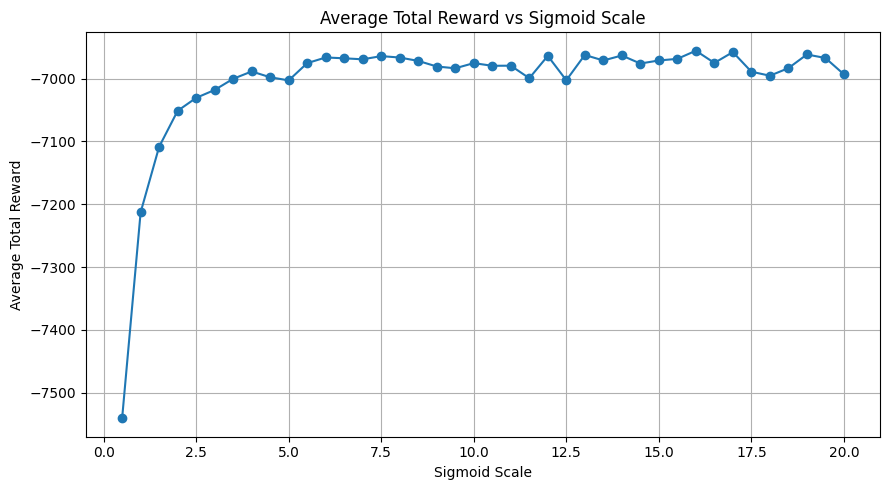

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x, scale=1.0):
    if x < 0:
        return 0.0
    return 1 / (1 + math.exp(-scale * x))

def run_episode(scale, epi_gen_seed, max_episode_steps, sleep_max, zero_hun_path):
    all_datas = []

    for epi_seed in epi_gen_seed:
        set_seed(epi_seed)
        Tsp1 = generate_random_tsp(max_episode_steps, 'TSP1')
        Tsp2 = generate_random_tsp(max_episode_steps, 'TSP2')

        from tclab import setup
        lab = setup(connected=False)
        env = lab(synced=False)

        env.Q1(0)
        env.Q2(0)

        tm = np.zeros(max_episode_steps)
        T1 = np.ones(max_episode_steps) * env.T1
        T2 = np.ones(max_episode_steps) * env.T2
        Q1 = np.zeros(max_episode_steps)
        Q2 = np.zeros(max_episode_steps)
        total_reward = 0.0

        for i in range(max_episode_steps):
            sim_time = i * sleep_max
            env.update(t=sim_time)
            tm[i] = sim_time

            T1[i] = env.T1
            T2[i] = env.T2

            eT1 = Tsp1[i] - T1[i]
            eT2 = Tsp2[i] - T2[i]

            Q1[i] = 100.0 * sigmoid(eT1, scale)
            Q2[i] = 100.0 * sigmoid(eT2, scale)

            env.Q1(Q1[i])
            env.Q2(Q2[i])

            reward = -np.linalg.norm([T1[i] - Tsp1[i], T2[i] - Tsp2[i]])
            total_reward += reward

        path = os.path.join(zero_hun_path, f"{epi_seed}epi")
        data = {
            "path": path,
            "tm": tm,
            "Q1": Q1,
            "Q2": Q2,
            "T1": T1,
            "T2": T2,
            "Tsp1": Tsp1,
            "Tsp2": Tsp2,
            "total_reward": total_reward,
        }
        all_datas.append(data)
        env.close()

    all_rewards = [d["total_reward"] for d in all_datas]
    mean_reward = np.mean(all_rewards)
    return mean_reward

# 실험 설정
scale_list = [i * 0.5 for i in range(1, 41)]  # 1.0 ~ 20.0
avg_rewards = []

# 실험 반복
for scale in scale_list:
    avg_reward = run_episode(scale, epi_gen_seed, max_episode_steps, sleep_max, zero_hun_path)
    avg_rewards.append(avg_reward)
    print(f"Scale={scale:.1f}, Avg Reward={avg_reward:.2f}")

# 결과 시각화
plt.figure(figsize=(9, 5))
plt.plot(scale_list, avg_rewards, marker='o')
plt.title("Average Total Reward vs Sigmoid Scale")
plt.xlabel("Sigmoid Scale")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()
